In [ ]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as dr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.gridspec as gridspec
import yfinance as yf

from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore")



In [ ]:
df = pd.read_csv("../dataset/data.csv")
df.set_index('Data e Hora', drop=True, inplace=True)
df.index = pd.to_datetime(df.index)
title = 'Energy production (2011 - 2025)'
title_renewable = 'Renewable Energy Production (2011 - 2025)'
title_non_renewable = 'Non-Renewable Energy Production (2011 - 2025)'
df.index = df.index + pd.DateOffset(months=6)
serie = "Energy Production"
serie_renewable = "Energy Renewable"
serie_non_renewable = "Energy Non-Renewable"
xlab = 'days/Year'
ylab = 'energy production (GWh)'
seasonal_periods = 365

color_non_renewable = '#b51b2b' 
color_renewable = '#2bb314' 


fittedValsToShow = 50;
previousStepsToShow=100
stepsToForecast=30

NameError: name 'pd' is not defined

## Define functions
    Defines helper functions

In [ ]:
# Compute MAE over an array of different horizons
def horizon_mae(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true.T);
    list_MAE = list()
    for i in horizonSteps:
        list_MAE.append(round(np.mean(ae[0,:i]), 2))
    return list_MAE;

In [ ]:
# Define Mean Absolute Percentage Error
def absolute_percentage_error(y_true, y_pred):
    if (len(y_true[y_true == 0])):
        print("Division by zero!")
        return None;
    else:
        return 100*(abs((y_pred - y_true.T) / y_true.T));

In [ ]:
# Compute MAPE over an array of different horizons
def horizon_mape(y_true, y_pred, horizonSteps):
    ape = absolute_percentage_error(y_true, y_pred);
    if ape is not None:
        list_MAPE = list()
        for i in horizonSteps:
            list_MAPE.append(round(np.mean(ape[0,:i]), 2))
        return list_MAPE;

In [ ]:
def ETS_plot(train, test, fit, forecast, title, xlab=xlab, ylab=ylab, previousStepsToShow=previousStepsToShow, stepsToForecast = stepsToForecast):
    plt.figure(figsize=(20,7))
    labels = ['Training and testing data', 'Fitted values', 'Predicted values']
    plt.title(title)
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, train[-previousStepsToShow:], 'k', linewidth = 3 )
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, fit[-previousStepsToShow-1:-1], 'b--' , linewidth = 2 )
    plt.plot(1+np.arange(stepsToForecast[-1]), forecast, 'r--*' , linewidth = 2 )
    plt.plot(1+np.arange(stepsToForecast[-1]), test, 'k-o' , linewidth = 3 )
    plt.legend(labels, loc='upper left')
    plt.grid(color='k', linestyle='--', linewidth=.2)
    plt.xlim([1-previousStepsToShow, stepsToForecast[-1]])
    plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
    plt.xlabel('Past and future working days')
    plt.ylabel(ylab)
    plt.show()

In [ ]:
def ETS_fit_plot(train, fit, title, xlab=xlab, ylab=ylab, fittedValsToShow=fittedValsToShow):
    plt.figure(figsize=(20,7))
    labels = ['Training data', 'Fitted values']
    plt.title(title)
    plt.plot(1+np.arange(fittedValsToShow)-fittedValsToShow, train[-fittedValsToShow:], 'k', linewidth = 3 )
    plt.plot(1+np.arange(fittedValsToShow)-fittedValsToShow, fit[-fittedValsToShow:], 'b--' , linewidth = 2 )
    plt.legend(labels, loc='upper left')
    plt.grid(color='k', linestyle='--', linewidth=.2)
    plt.xlim([1-fittedValsToShow, 0])
    plt.xticks(1+np.arange(-fittedValsToShow, 0))
    plt.xlabel('Fitted Values to Training Data')
    plt.ylabel(ylab)
    plt.show()

#### Nota 
- Nota: Aplicando uma escala logarítmica aos dados, pode transformar um modelo multiplicativo num aditivo
#### Tipo de modelo que esperamos:
- 'additive' - A amplitude do efeito sazonal mantém-se constante todos os anos
- 'multiplicative' - Os efeitos sazonais e outros atuam proporcionalmente sobre a série

- producao_renovavel é a agregação das colunas hidrica, eolica, solar, ondas, biomassa
- producao_nao_renovavel é a agregação das colunas carvao, gas_natural, termica, producao_por_bombagem


In [ ]:
Renoable_column = ['producao_renovavel','hidrica' ,'biomassa','eolica','solar','ondas']
NoneRenoable_column = ['producao_nao_renovavel','termica' ,'gas_natural','carvao','producao_por_bombagem']
Export_import_column = ['exportacao','importacao'] 

In [ ]:
df_renewable = df['producao_renovavel']
df_non_renewable = df['producao_nao_renovavel']

In [ ]:
stepsToForecast = [30]

# Calculate the split index for the last 20% of the data
split_index = int(len(df_renewable) * 0.8)

# Split the data into training and testing sets
df_train = df_non_renewable[:split_index].rename("train")
df_test = df_non_renewable[split_index:].rename("test")

title = "Energy renewable production (2011 - 2025)"
serie = "Energy renewable Production"
xlab = "days/Year"
ylab = "renewable energy production (GWh)"



In [ ]:
TS_str = ['TS (N, N)', 'TS (A, N)', 'TS (Ad, N)', 'TS (N, A)', 'TS (A, A)', 'TS (Ad, A)', 'TS (N, M)', 'TS (A, M)', 'TS (Ad, M)']
TS_print = []

previousStepsToShow = 15;
fittedValsToShow = df_test.size;

# Model Training
    This section will train the distinct Exponential Smoothing models and also show their fit to the Time-Series in order to understand their potential. 

## Single Exponential Smoothing

### TS (N, N) - Simple Exponential Smoothing

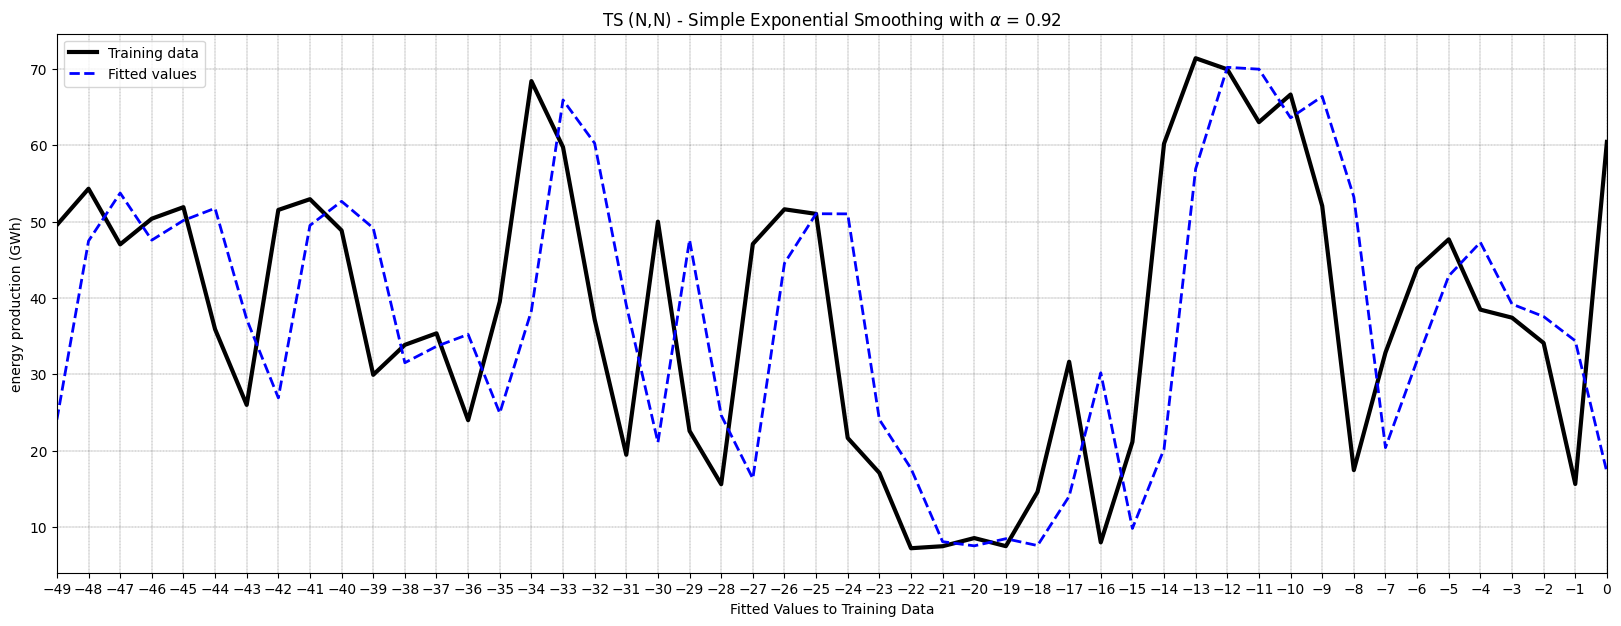

In [ ]:
model_TS_NN = ExponentialSmoothing(df_train.values, 
                                   trend=None, 
                                   damped=False,
                                   seasonal=None)
TS_NN = model_TS_NN.fit(smoothing_level=None)

if (TS_NN.mle_retvals.success):
    TS_NN_forecast = TS_NN.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_NN_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (N,N) - Simple Exponential Smoothing with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_NN.params['smoothing_level'],2))
           
        ETS_fit_plot(train = df_train.values, 
                     fit = TS_NN.fittedvalues, 
                     title = title)
        
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

## Double Exponential Smoothing

### TS (A, N) - Holt’s linear method

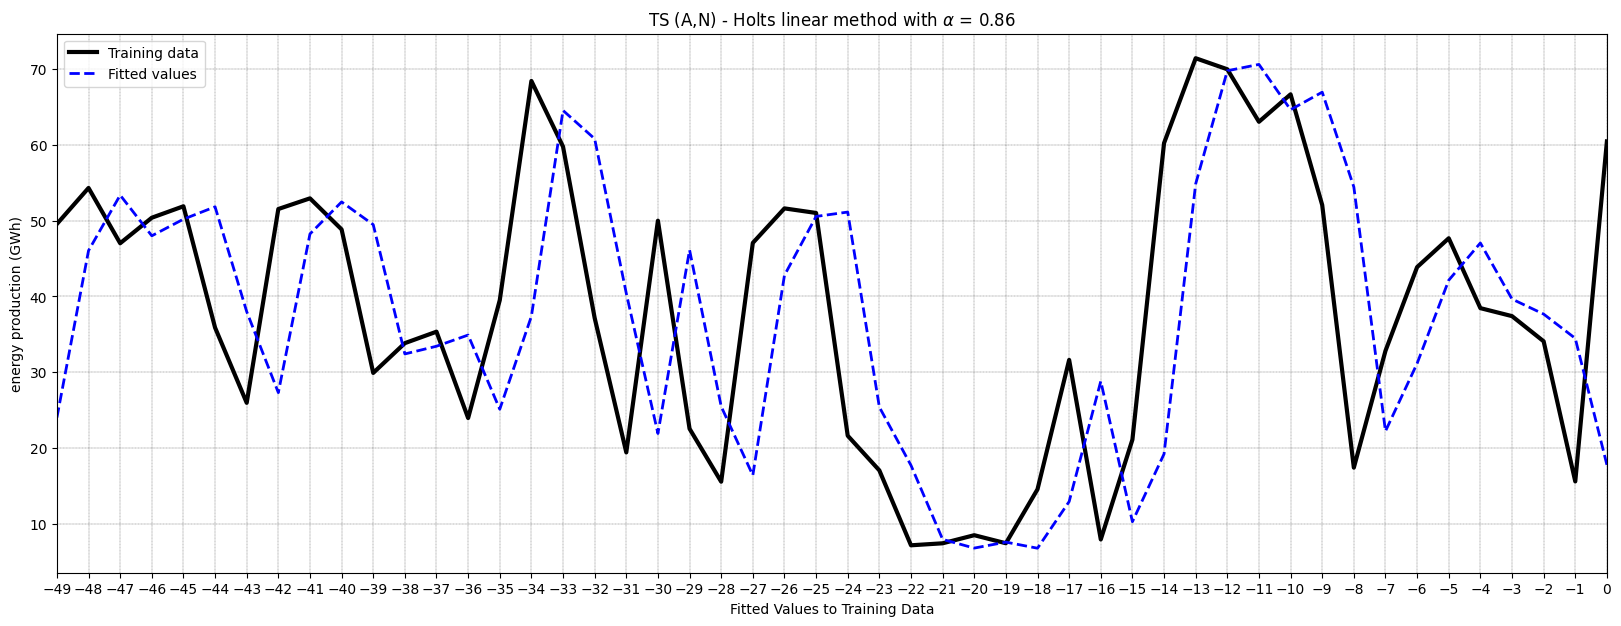

In [ ]:
model_TS_AN = ExponentialSmoothing(df_train.values, 
                                   trend='add', 
                                   damped=False,
                                   seasonal=None)
TS_AN = model_TS_AN.fit(smoothing_level=None, 
                        smoothing_slope=None)

if (TS_AN.mle_retvals.success):
    TS_AN_forecast = TS_AN.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AN_forecast).any()):
        TS_print.append(True)
        
        title = 'TS (A,N) - Holts linear method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AN.params['smoothing_level'],2))
        
        if 'smoothing_slope' in TS_AN.params:
            title += r', $\beta$' + ' = ' + str(round(TS_AN.params['smoothing_slope'],2))

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_AN.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False)
        print('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False)
    print('ConvergenceWarning: Optimization failed to converge.')

### TS (Ad, N) - Additive damped trend method

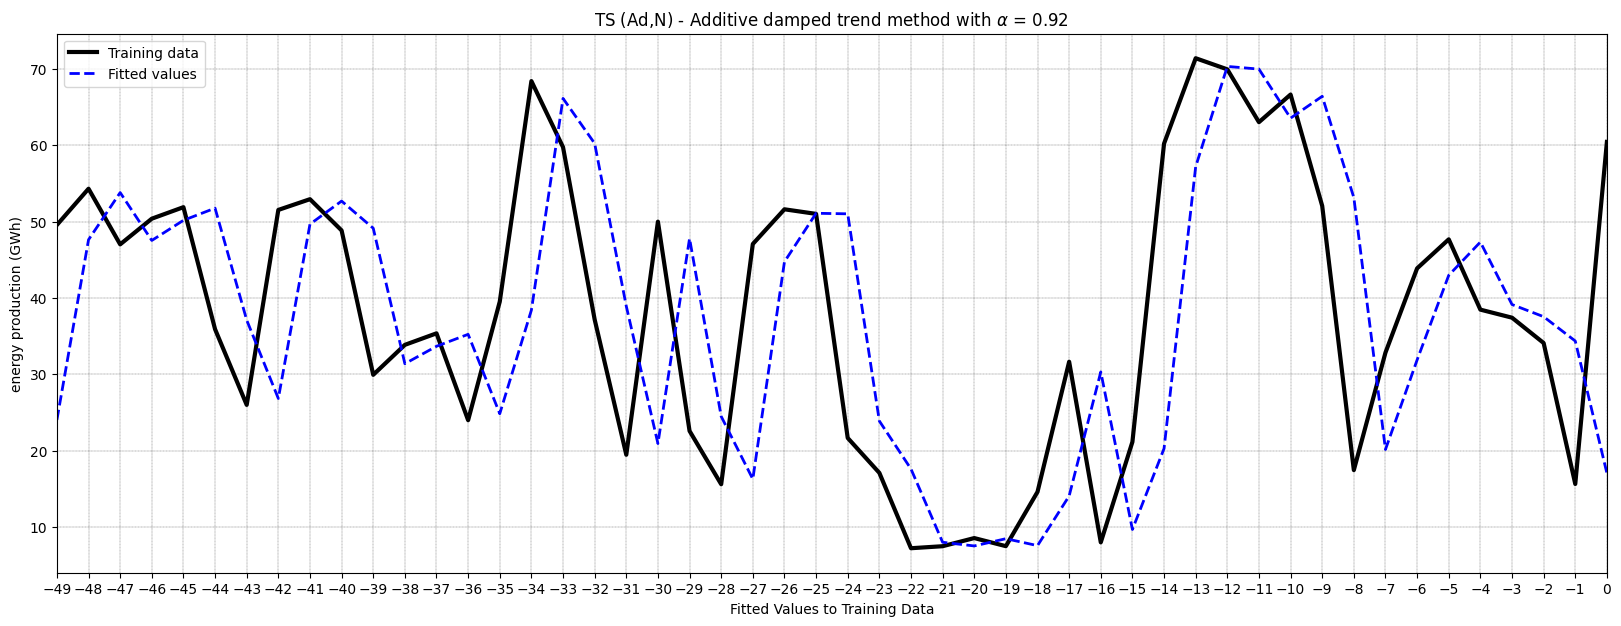

In [ ]:
model_TS_AdN = ExponentialSmoothing(df_train.values, 
                                    trend='add', 
                                    damped=True,
                                    seasonal=None)
TS_AdN = model_TS_AdN.fit(smoothing_level=None, 
                          smoothing_slope=None, 
                          damping_slope=None)

if (TS_AdN.mle_retvals.success):
    TS_AdN_forecast = TS_AdN.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AdN_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (Ad,N) - Additive damped trend method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AdN.params['smoothing_level'],2))
        
        if 'smoothing_slope' in TS_AdN.params:
            title += r', $\beta$' + ' = ' + str(round(TS_AdN.params['smoothing_slope'],2))
        
        if 'damping_slope' in TS_AdN.params:
            title += r', $\zeta$' + ' = ' + str(round(TS_AdN.params['damping_slope'],2))

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_AdN.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

## Triple Exponential Smoothing

### TS (N, A) method

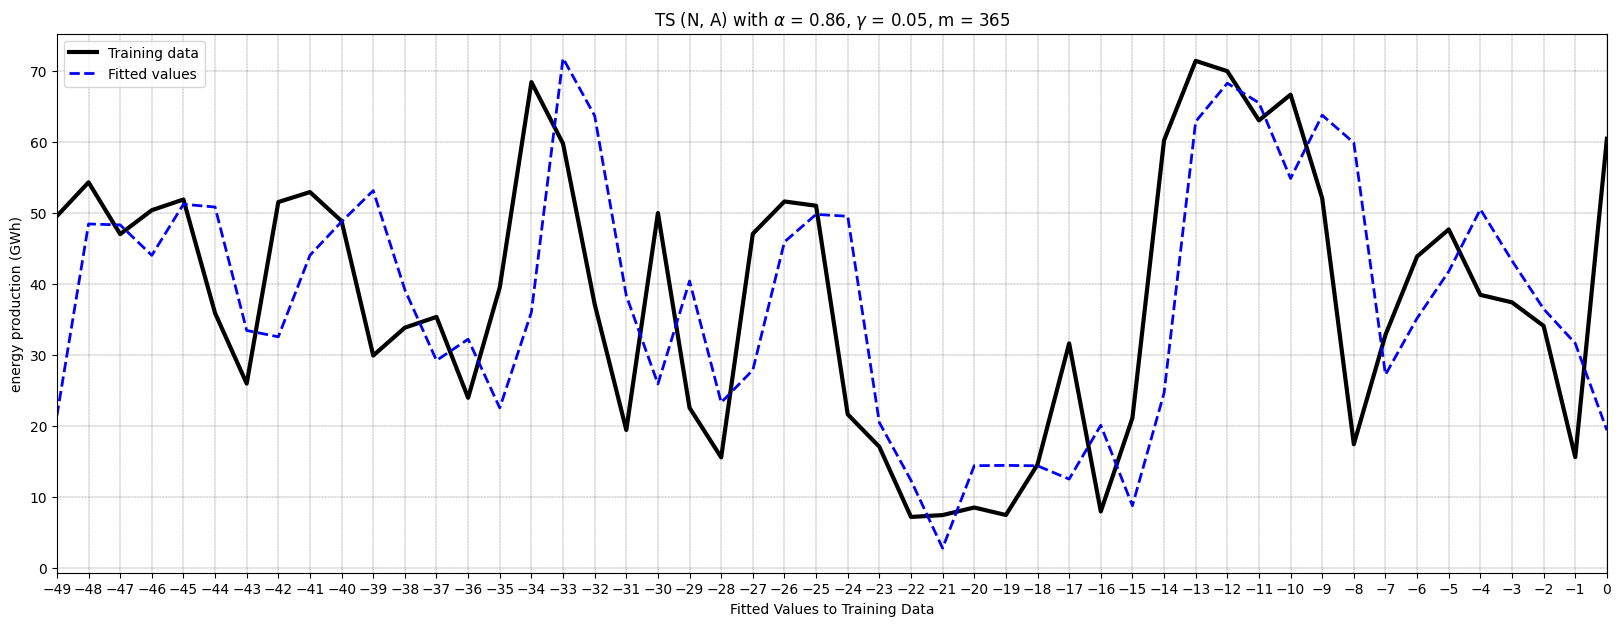

In [ ]:
model_TS_NA = ExponentialSmoothing(df_train.values, 
                                   trend=None, 
                                   damped=False, 
                                   seasonal='add', 
                                   seasonal_periods=seasonal_periods)
TS_NA = model_TS_NA.fit(smoothing_level=None, 
                        smoothing_seasonal=None)

if (TS_NA.mle_retvals.success):
    TS_NA_forecast = TS_NA.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_NA_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (N, A) with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_NA.params['smoothing_level'],2)) \
            + r', $\gamma$' + ' = ' + str(round(TS_NA.params['smoothing_seasonal'],2)) \
            + ', m = ' + str(model_TS_NA.seasonal_periods);

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_NA.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

### TS (A, A) - Additive Holt-Winters method

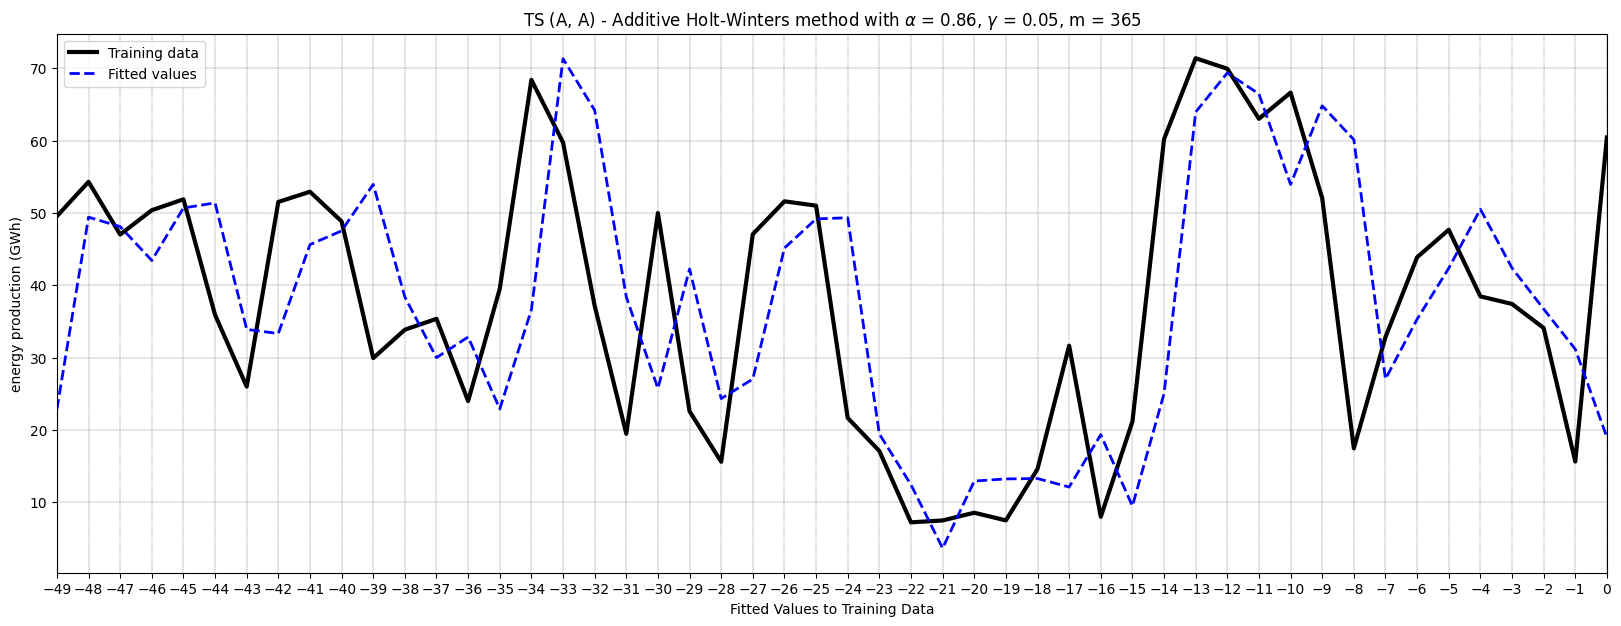

In [ ]:
model_TS_AA = ExponentialSmoothing(df_train.values, 
                                   trend='add', 
                                   damped=False, 
                                   seasonal='add', 
                                   seasonal_periods=seasonal_periods)
TS_AA = model_TS_AA.fit(smoothing_level=None, 
                        smoothing_slope=None, 
                        smoothing_seasonal=None)

if (TS_AA.mle_retvals.success):
    TS_AA_forecast = TS_AA.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AA_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (A, A) - Additive Holt-Winters method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AA.params['smoothing_level'],2))
        
        if 'smoothing_slope' in TS_AA.params:
            title += r', $\beta$' + ' = ' + str(round(TS_AA.params['smoothing_slope'],2))
        
        if 'smoothing_seasonal' in TS_AA.params:
            title += r', $\gamma$' + ' = ' + str(round(TS_AA.params['smoothing_seasonal'],2))
        
        title += ', m = ' + str(model_TS_AA.seasonal_periods)

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_AA.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

### TS (Ad, A) method

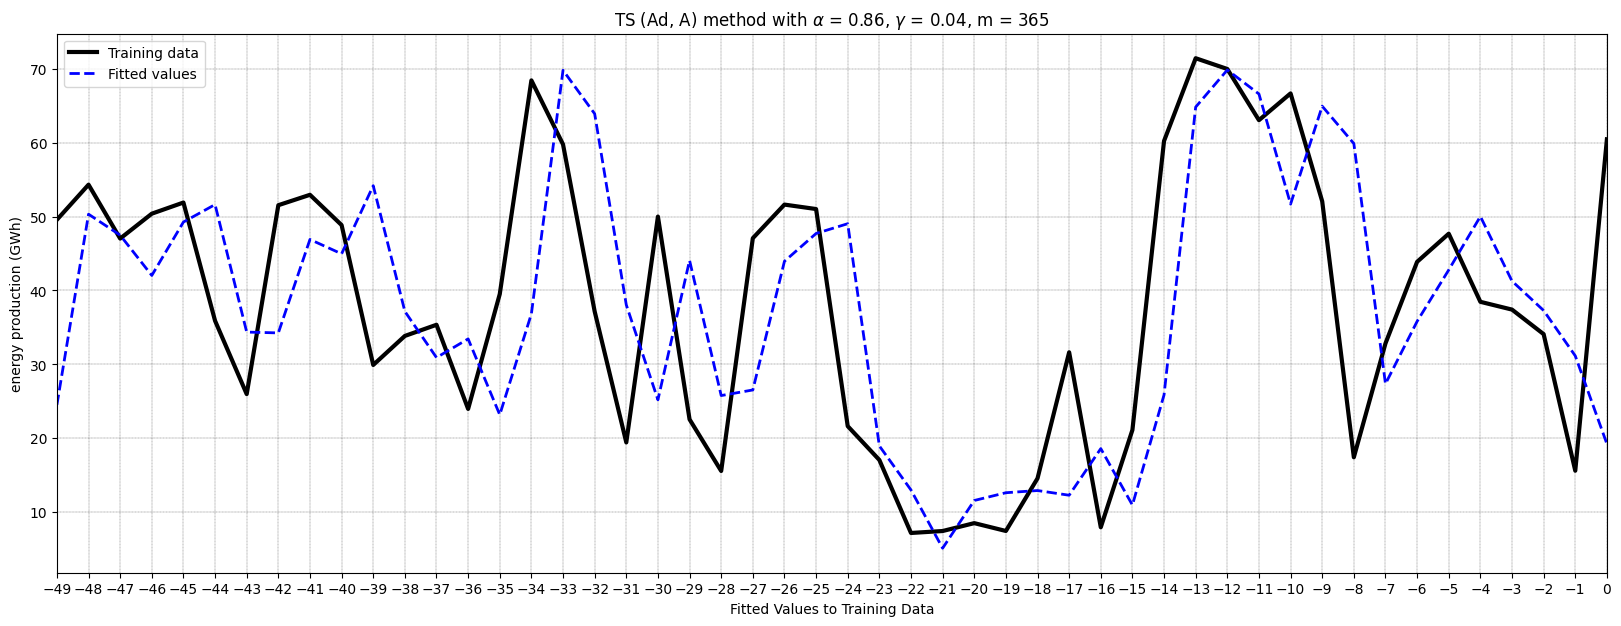

In [ ]:
model_TS_AdA = ExponentialSmoothing(df_train.values, 
                                    trend='add', 
                                    damped=True, 
                                    seasonal='add', 
                                    seasonal_periods=seasonal_periods)

TS_AdA = model_TS_AdA.fit(smoothing_level=None, 
                          smoothing_slope=None, 
                          damping_slope=None, 
                          smoothing_seasonal=None)

if (TS_AdA.mle_retvals.success):
    TS_AdA_forecast = TS_AdA.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AdA_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (Ad, A) method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AdA.params['smoothing_level'],2))
        
        if 'smoothing_slope' in TS_AdA.params:
            title += r', $\beta$' + ' = ' + str(round(TS_AdA.params['smoothing_slope'],2))
        
        if 'damping_slope' in TS_AdA.params:
            title += r', $\zeta$' + ' = ' + str(round(TS_AdA.params['damping_slope'],2))
        
        if 'smoothing_seasonal' in TS_AdA.params:
            title += r', $\gamma$' + ' = ' + str(round(TS_AdA.params['smoothing_seasonal'],2))
        
        title += ', m = ' + str(model_TS_AA.seasonal_periods)

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_AdA.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

### TS (N, M) method

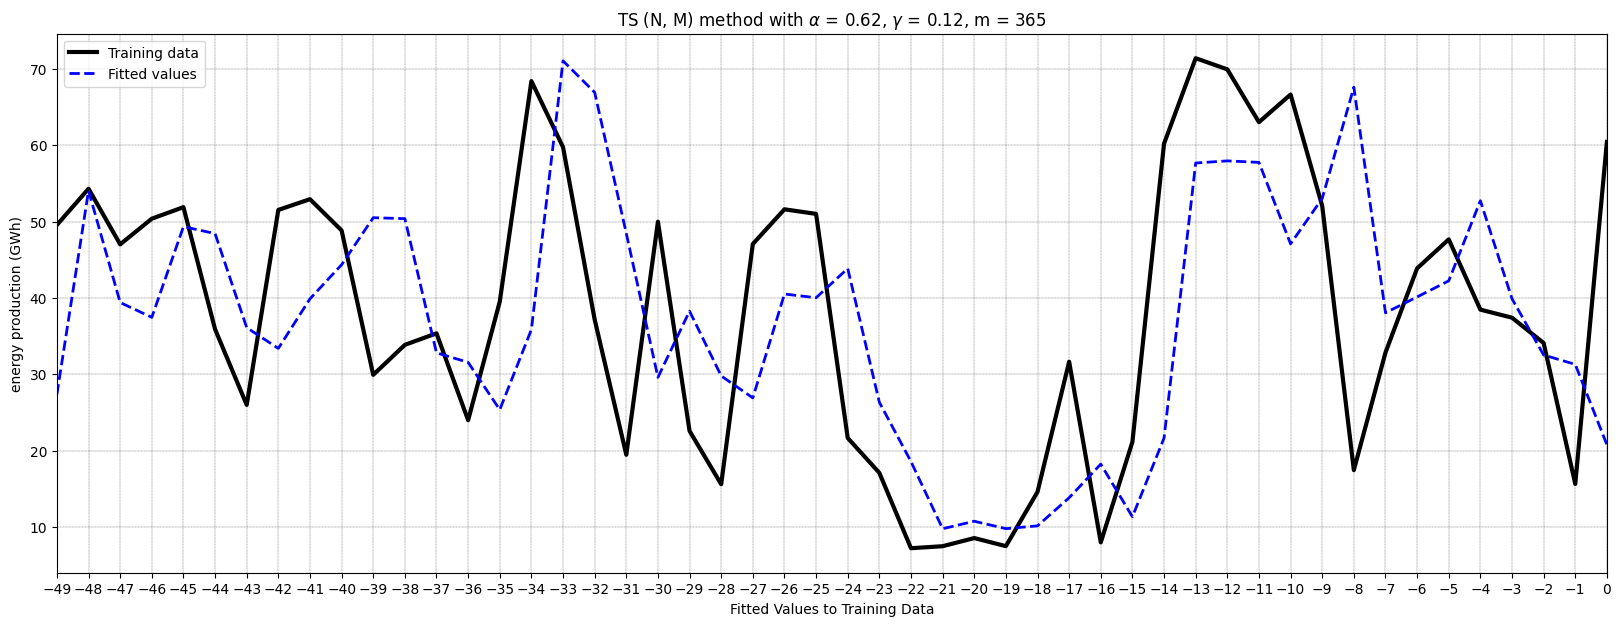

In [ ]:
model_TS_NM = ExponentialSmoothing(df_train.values, 
                                    trend=None, 
                                    damped=False, 
                                    seasonal='mul', 
                                    seasonal_periods=seasonal_periods)
TS_NM = model_TS_NM.fit(smoothing_level=None,  
                          smoothing_seasonal=None)

if (TS_NM.mle_retvals.success):
    TS_NM_forecast = TS_NM.forecast(stepsToForecast[-1])
    
    if (~np.isnan(TS_NM_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (N, M) method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_NM.params['smoothing_level'],2)) \
            + r', $\gamma$' + ' = ' + str(round(TS_NM.params['smoothing_seasonal'],2)) \
            + ', m = ' + str(model_TS_AA.seasonal_periods);

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_NM.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

### TS (A, M) Multiplicative Holt-Winters’ method

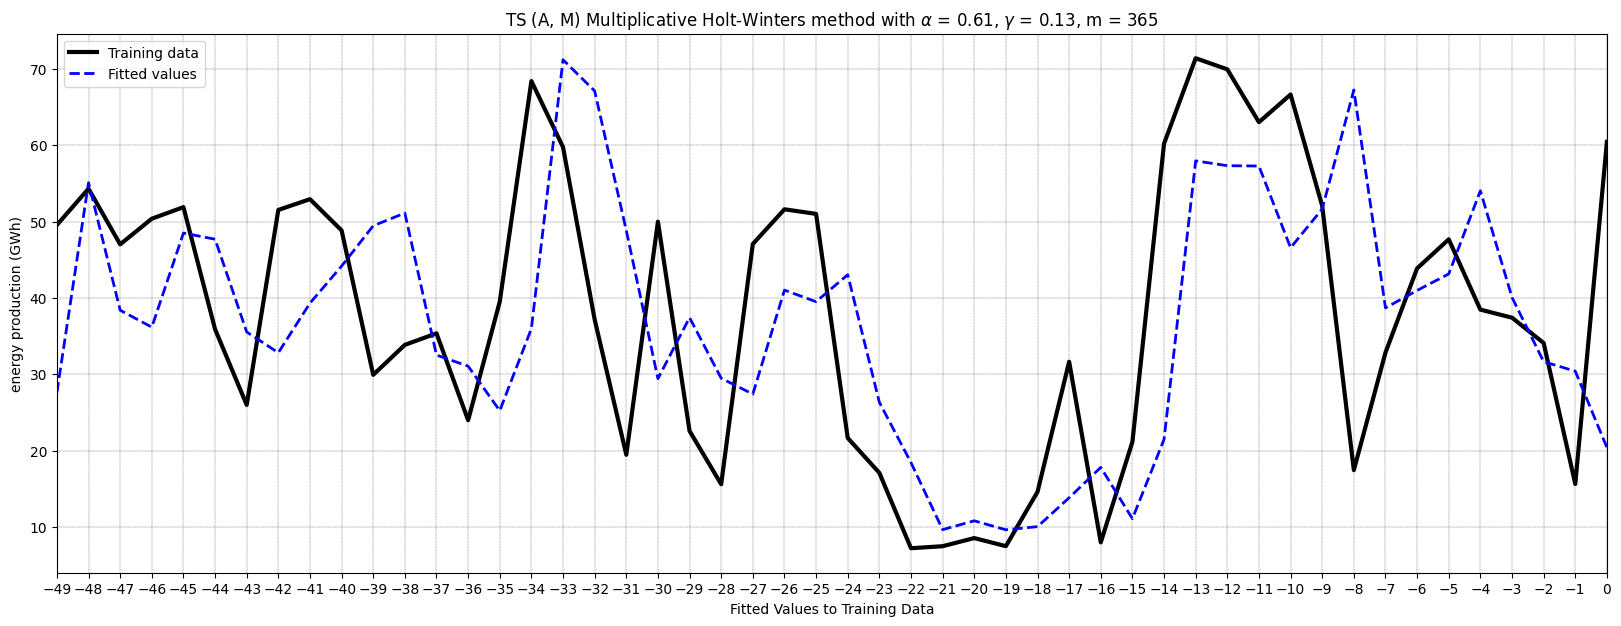

In [ ]:
model_TS_AM = ExponentialSmoothing(df_train.values, 
                                    trend='add', 
                                    damped=False, 
                                    seasonal='mul', 
                                    seasonal_periods=seasonal_periods)
TS_AM = model_TS_AM.fit(smoothing_level=None, 
                        smoothing_slope=None, 
                        smoothing_seasonal=None)

if (TS_AM.mle_retvals.success):
    TS_AM_forecast = TS_AM.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AM_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (A, M) Multiplicative Holt-Winters method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AM.params['smoothing_level'],2))
        
        if 'smoothing_slope' in TS_AM.params:
            title += r', $\beta$' + ' = ' + str(round(TS_AM.params['smoothing_slope'],2))
        
        if 'smoothing_seasonal' in TS_AM.params:
            title += r', $\gamma$' + ' = ' + str(round(TS_AM.params['smoothing_seasonal'],2))
        
        title += ', m = ' + str(model_TS_AM.seasonal_periods)

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_AM.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

### TS (Ad, M) Holt-Winters’ damped method

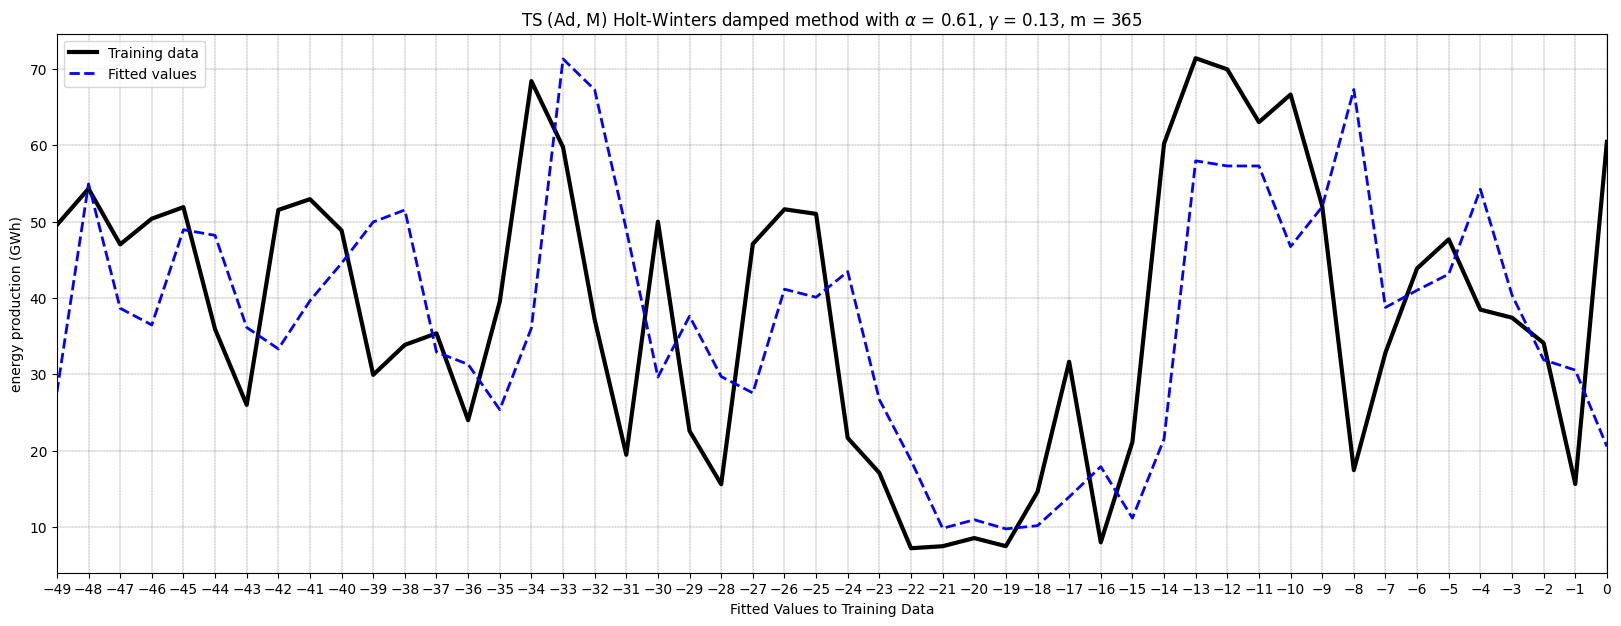

In [ ]:
model_TS_AdM = ExponentialSmoothing(df_train.values, 
                                    trend='add', 
                                    damped=True, 
                                    seasonal='mul', 
                                    seasonal_periods=seasonal_periods)
TS_AdM = model_TS_AdM.fit(smoothing_level=None, 
                          smoothing_slope=None, 
                          damping_slope=None, 
                          smoothing_seasonal=None)

if (TS_AdM.mle_retvals.success):
    TS_AdM_forecast = TS_AdM.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AdM_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (Ad, M) Holt-Winters damped method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AdM.params['smoothing_level'],2))
        
        if 'smoothing_slope' in TS_AdM.params:
            title += r', $\beta$' + ' = ' + str(round(TS_AdM.params['smoothing_slope'],2))
        
        if 'damping_slope' in TS_AdM.params:
            title += r', $\zeta$' + ' = ' + str(round(TS_AdM.params['damping_slope'],2))
        
        if 'smoothing_seasonal' in TS_AdM.params:
            title += r', $\gamma$' + ' = ' + str(round(TS_AdM.params['smoothing_seasonal'],2))
        
        title += ', m = ' + str(model_TS_AdM.seasonal_periods)

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_AdM.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

# Model Selection
    This section will show Akaike Information Criteria (AIC) and Bayesian Information Criteria (BIC)

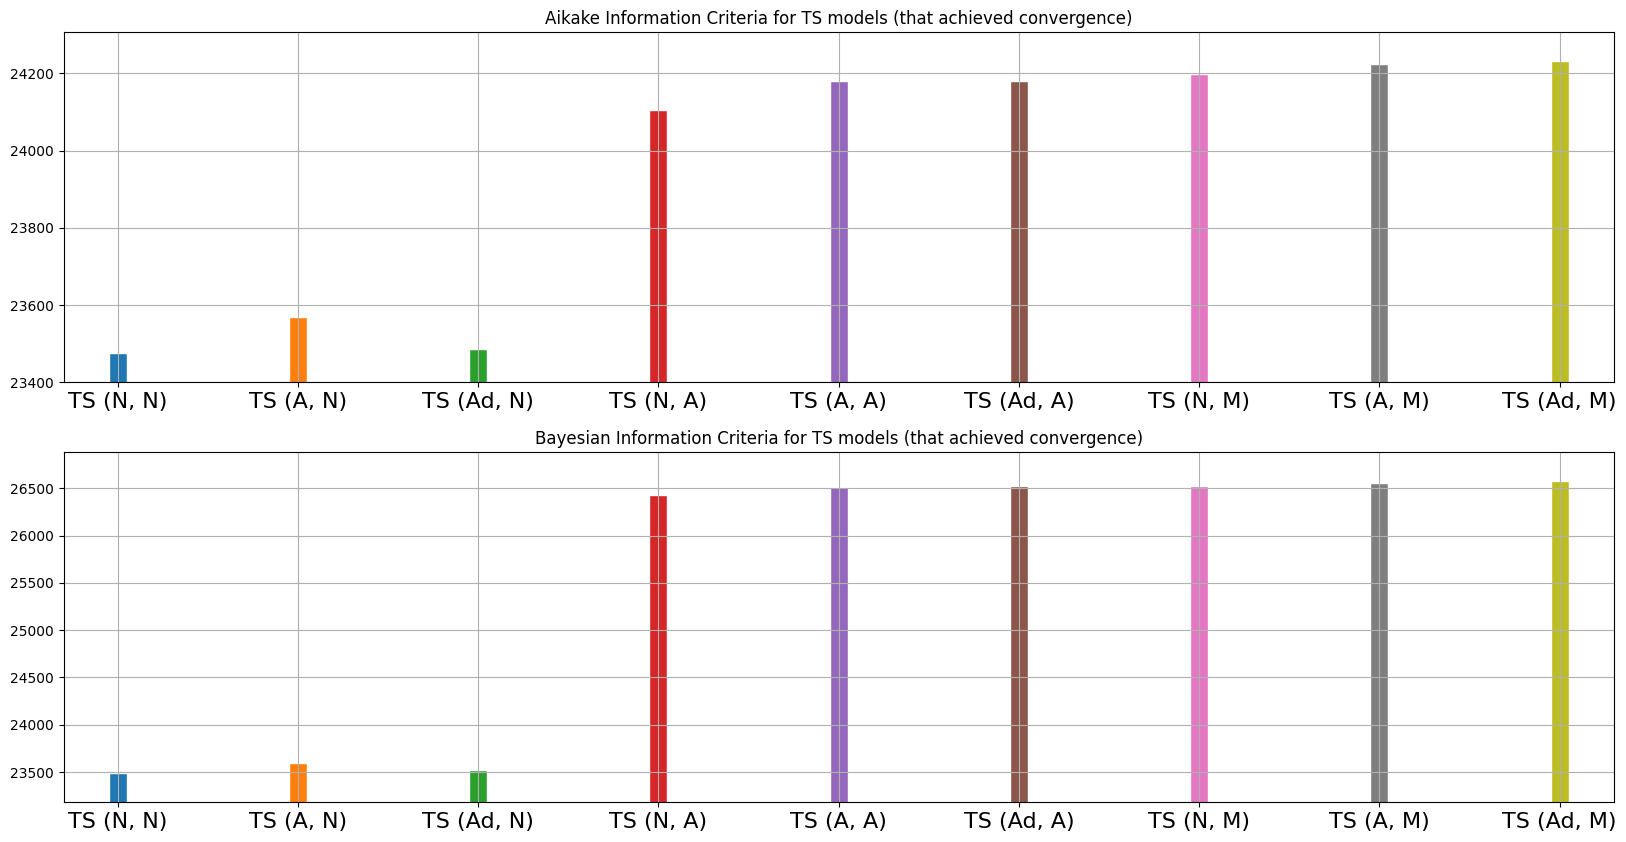

In [ ]:
plt.figure(figsize=(20,10))

params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)

TS = [TS_NN, TS_AN, TS_AdN, TS_NA, TS_AA, TS_AdA, TS_NM, TS_AM, TS_AdM]

#TS = [TS_NN, TS_AN, TS_AdN]

spacing = 0.05
barWidth = 0.1
r = np.arange(len(TS)) - (len(TS)/2)*spacing

plt.subplot(211)
TS_val = []
for i in np.arange(len(TS)):
    if(TS_print[i]):
        plt.bar(r[i], TS[i].aic,  width=barWidth, edgecolor='white', label=TS_str[i])
        TS_val.append(TS[i].aic)
plt.axis((r[0]-.3, r[8]+.3, min(TS_val)-0.1*(max(TS_val)-min(TS_val)), max(TS_val)+0.1*(max(TS_val)-min(TS_val))))
plt.xticks(r, TS_str, fontsize='16')
plt.title('Aikake Information Criteria for TS models (that achieved convergence)')
plt.grid()

plt.subplot(212)
TS_val = []
for i in np.arange(len(TS)):
    if(TS_print[i]):
        plt.bar(r[i], TS[i].bic,  width=barWidth, edgecolor='white', label=TS_str[i])
        TS_val.append(TS[i].bic)
plt.axis((r[0]-.3, r[8]+.3, min(TS_val)-0.1*(max(TS_val)-min(TS_val)), max(TS_val)+0.1*(max(TS_val)-min(TS_val))))
plt.xticks(r, TS_str, fontsize='16')
plt.title('Bayesian Information Criteria for TS models (that achieved convergence)')
plt.grid()
plt.show()

## Model Validation
    The previous Model Training section and the fitted values plot allows to understand which model is likely to perform better. The previous Model Selection section allows to understand which models achieved convergence. 
    This section will exploit the residuals obtained on one of the selected model, and allows to "validate" our choice.

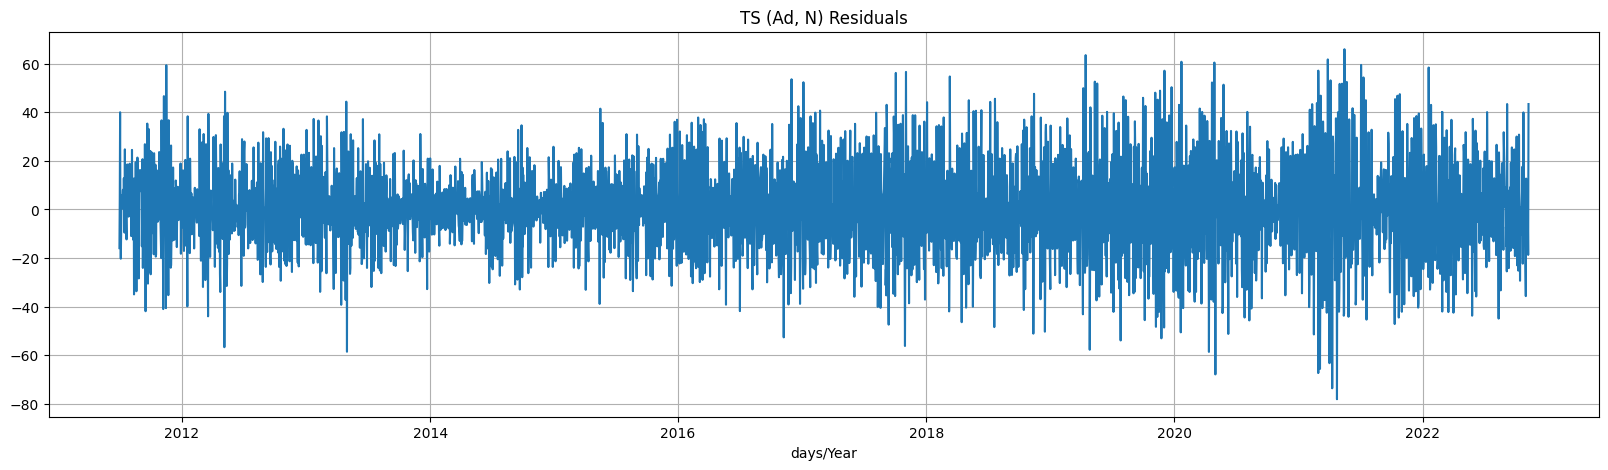

In [ ]:
# Pick you favourite's models
TS_model = 'TS (Ad, N)'
TS_model_forecast = TS_AdN_forecast

# Plot model residuals
model_fit = TS[TS_str.index(TS_model)]
df_res = pd.DataFrame({"resid": model_fit.resid}, index=df_train.index)
plt.figure(figsize=(20,5))
plt.plot(df_res.index, df_res.values)
plt.xlabel(xlab)
plt.title(TS_model +' Residuals')
plt.grid()
plt.show()

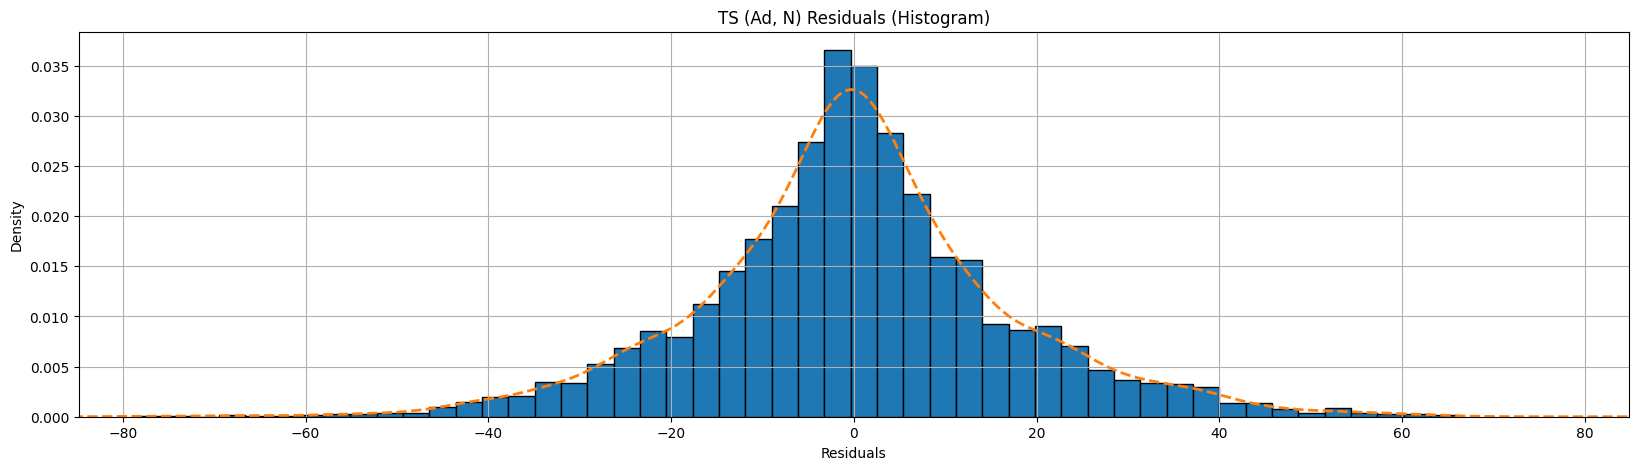

Mean: 0.072277
Variance: 287.342463


In [ ]:
# Plot histogram
plt.figure(figsize=(20,5))
plt.title(TS_model + ' Residuals (Histogram)')
hist_res = df_res['resid'].hist(bins=50, density=True, edgecolor='black')
df_res['resid'].plot(kind='kde', linewidth=2, linestyle='--')
#plt.text(np.std(df_res.values), hist_res.get_ylim()[1]*0.8, r'$\mu = $'+ str(round(np.mean(df_res), 6)))
#plt.text(np.std(df_res.values), hist_res.get_ylim()[1]*0.75, r'$\sigma^2 = $' + str(round(np.var(df_res), 6)))
plt.xlabel('Residuals')
limX = np.mean(df_res.values)+5*np.std(df_res.values)
plt.xlim((-limX, limX))
plt.grid()
plt.show()

print ("Mean: %.6f" % np.mean(df_res))
print ("Variance: %.6f" % np.var(df_res))

## Normality test

### Kurtosis and Kurtosis Test
    Compute the kurtosis (Fisher or Pearson) of a dataset.
    Kurtosis is the fourth central moment divided by the square of the variance. If Fisher's definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution. If bias is False then the kurtosis is calculated using k statistics to eliminate bias coming from biased moment estimators

    Test whether a dataset has normal kurtosis.
    This function tests the null hypothesis that the kurtosis of the population from which the sample was drawn is that of the normal distribution: kurtosis = 3(n-1)/(n+1).

In [ ]:
k, kpval = kurtosistest(df_res['resid'].values)
kurtosis_val = kurtosis(df_res['resid'].values, fisher=True)
# If Fisher’s definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution.
print("Kurtosis Test")
print("Statistic: %.4f" % k)
print("p-value: %.4f" % kpval)
print("Kurtosis value: %.4f" % kurtosis_val)

Kurtosis Test
Statistic: 10.2511
p-value: 0.0000
Kurtosis value: 1.2037


### Skew and Skewness Test
    Compute the skewness of a data set.
    For normally distributed data, the skewness should be about 0. For unimodal continuous distributions, a skewness value > 0 means that there is more weight in the right tail of the distribution. The function `skewtest` can be used to determine if the skewness value is close enough to 0, statistically speaking.

    Test whether the skew is different from the normal distribution.
    This function tests the null hypothesis that the skewness of the population that the sample was drawn from is the same as that of a corresponding normal distribution.

In [ ]:
s, spval = skewtest(df_res['resid'].values)
skew_val = skew(df_res['resid'].values)
print("Skew Test")
print("Statistic: %.4f" % s)
print("p-value: %.4f" % spval) 
print("Skewness value: %.4f" % skew_val) 

Skew Test
Statistic: 1.7417
p-value: 0.0816
Skewness value: 0.0662


### Jarque-Bera test
    Perform the Jarque-Bera goodness of fit test on sample data.
    The Jarque-Bera test tests whether the sample data has the skewness and kurtosis matching a normal distribution.

In [ ]:
jb, jbpval= stats.jarque_bera(df_res['resid'].values)
print("Jarque-Bera Test")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)

Jarque-Bera Test
Statistic: 253.3866
p-value: 0.0000


### Kolmogorov-Smirnov test
    Perform the Kolmogorov-Smirnov test for goodness of fit.
    This performs a test of the distribution G(x) of an observed random variable against a given distribution F(x). Under the null hypothesis the two distributions are identical, G(x)=F(x). The alternative hypothesis can be either 'two-sided' (default), 'less' or 'greater'. The KS test is only valid for continuous distributions.

In [ ]:
ks, kspval = stats.kstest(df_res['resid'].values, 'norm')
print("Kolmogorov-Smirnov Test")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 

Kolmogorov-Smirnov Test
Statistic: 0.4141
p-value: 0.0000


## Engle's Test for Autoregressive Conditional Heteroscedasticity (ARCH)

In [ ]:
lm, lmpval, fval, fpval = het_arch(df_res['resid'].values)
print('Lagrange multiplier test statistic')
print("LM Statistic: %.4f" % lm)
print("LM-Test p-value: %.4f" % lmpval)
print('')
print('fstatistic for F test')
print("F Statistic: %.4f" % fval)
print("F-Test p-value: %.4f" % fpval)
print('')

Lagrange multiplier test statistic
LM Statistic: 561.4580
LM-Test p-value: 0.0000

fstatistic for F test
F Statistic: 64.7895
F-Test p-value: 0.0000



## Test for No Autocorrelation

### Brock–Dechert–Scheinkman test
    Calculate the BDS test statistic for independence of a time series

In [ ]:
# Computing BDS
# Tests independent and identically distributed (i.i.d.) time series
result = bds(df_res['resid'].values, max_dim=6);
print("BDS Test")
print("Dim 2: z-static %.4f Prob %.4f" % (result[0][0], result[1][0]))
print("Dim 3: z-static %.4f Prob %.4f" % (result[0][1], result[1][1]))
print("Dim 4: z-static %.4f Prob %.4f" % (result[0][2], result[1][2]))
print("Dim 5: z-static %.4f Prob %.4f" % (result[0][3], result[1][3]))
print("Dim 6: z-static %.4f Prob %.4f" % (result[0][4], result[1][4]))

BDS Test
Dim 2: z-static 8.5474 Prob 0.0000
Dim 3: z-static 13.0881 Prob 0.0000
Dim 4: z-static 13.0263 Prob 0.0000
Dim 5: z-static 12.5569 Prob 0.0000
Dim 6: z-static 14.1655 Prob 0.0000


### Box-Pierce and Ljung-Box tests
    Ljung-Box and Box-Pierce statistic differ in their scaling of the autocorrelation function. Ljung-Box test is reported to have better small sample properties.

In [ ]:
maxLags = 21

# Perform the Ljung-Box and Box-Pierce tests
result = acorr_ljungbox(df_res['resid'].values, lags=range(1, maxLags), boxpierce=True)

# Extract the test statistics and p-values
lbvalue, pvalue = result['lb_stat'], result['lb_pvalue']
bpvalue, bppvalue = result['bp_stat'], result['bp_pvalue']

# Create a MultiIndex for the DataFrame
index = pd.MultiIndex.from_product([range(1, maxLags)], names=['lags'])
columns = pd.MultiIndex.from_product([['Box-Pierce', 'Ljung-Box'], ['Stats', 'p-value']], names=['Test', 'Statistics'])

# Combine the results into a DataFrame
data = np.array([bpvalue, bppvalue, lbvalue, pvalue], dtype=float)
boxTests = pd.DataFrame(data.T, index=index, columns=columns)

# Display the results
boxTests

Test         Box-Pierce                   Ljung-Box               
Statistics        Stats        p-value        Stats        p-value
lags                                                              
1              2.508411   1.132401e-01     2.510226   1.131097e-01
2            464.186957  1.596184e-101   464.634300  1.276273e-101
3            542.670588  2.695166e-117   543.212626  2.056360e-117
4            578.796253  6.011521e-124   579.390610  4.470598e-124
5            771.332882  1.838918e-164   772.252627  1.163099e-164
6            773.751511  7.216928e-164   774.675928  4.556718e-164
7           1918.474377   0.000000e+00  1921.887323   0.000000e+00
8           1925.495300   0.000000e+00  1928.925208   0.000000e+00
9           2116.448042   0.000000e+00  2120.385558   0.000000e+00
10          2149.257389   0.000000e+00  2153.290074   0.000000e+00
11          2187.055822   0.000000e+00  2191.207311   0.000000e+00
12          2342.941271   0.000000e+00  2347.620547   0.000000e+00
13          2349.517976   0.000000e+00  2354.221115   0.000000e+00
14          3353.926930   0.000000e+00  3362.518418   0.000000e+00
15          3357.629932   0.000000e+00  3366.236655   0.000000e+00
16          3537.464452   0.000000e+00  3546.854767   0.000000e+00
17          3563.380732   0.000000e+00  3572.890275   0.000000e+00
18          3591.532370   0.000000e+00  3601.178273   0.000000e+00
19          3770.878338   0.000000e+00  3781.436611   0.000000e+00
20          3780.501330   0.000000e+00  3791.110901   0.000000e+00

### QQplot
    Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution.
    Can take arguments specifying the parameters for dist or fit them automatically.

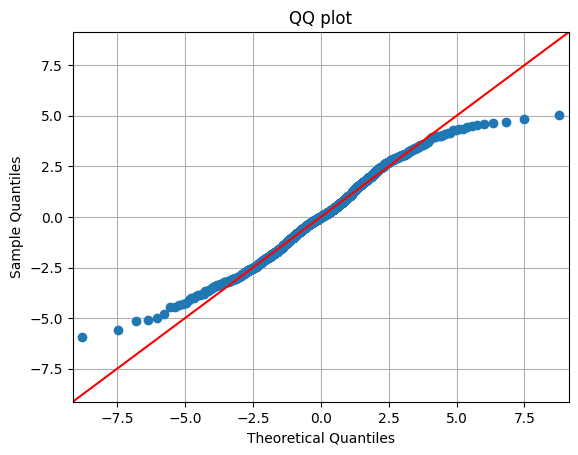

In [ ]:
qqplot(df_res['resid'].values, stats.t, fit=True, line='45')
plt.title('QQ plot');
plt.grid()
plt.show()

### Plot Auto-correlation and Partial Auto-correlation functions
    Plots lags on the horizontal and the correlations on vertical axis.

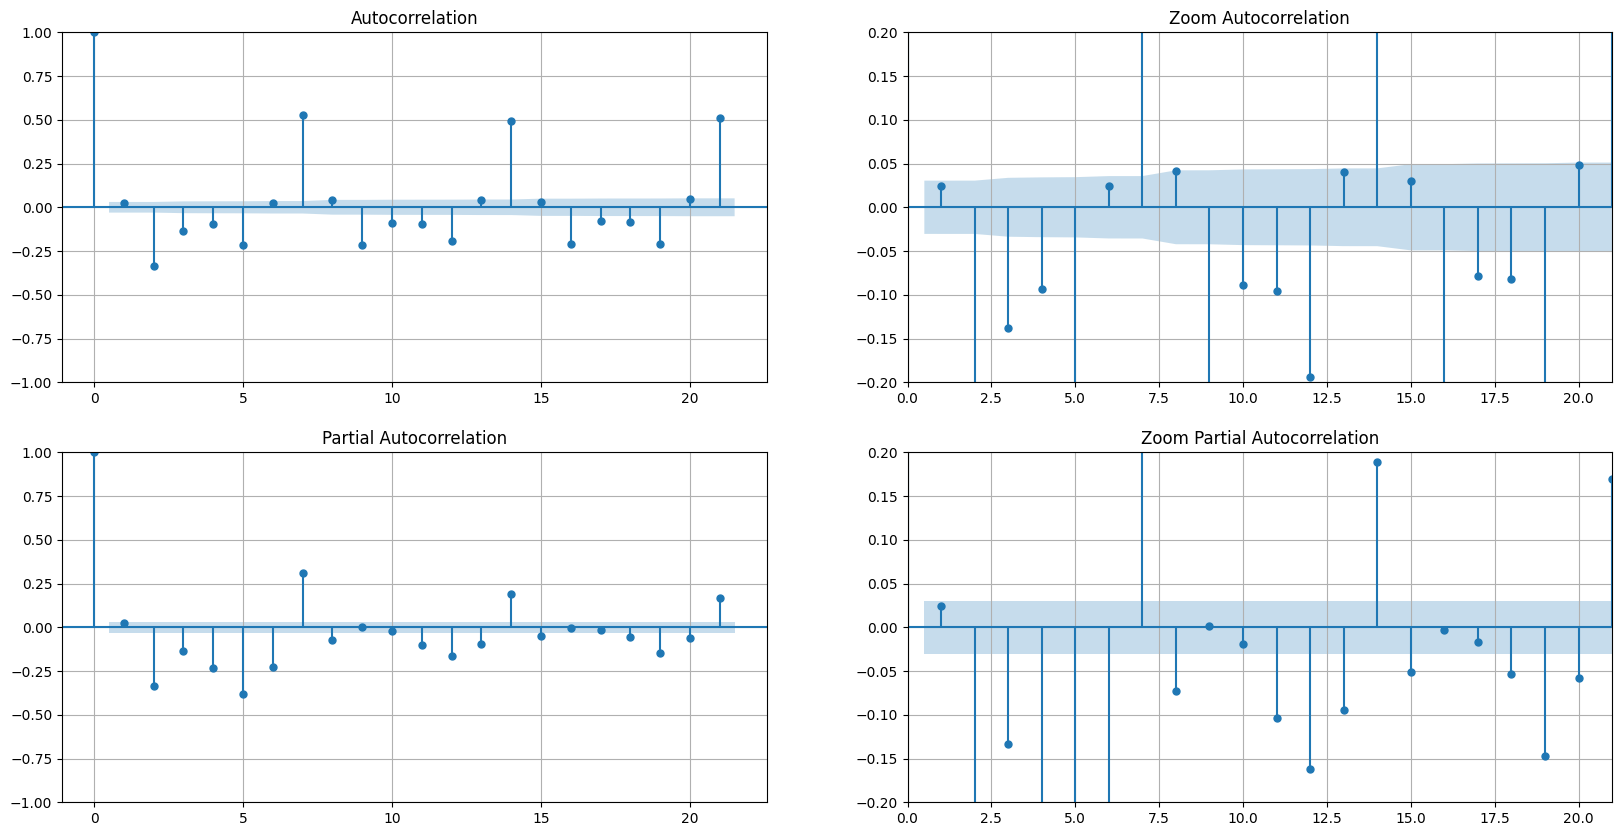

In [ ]:
fig = plt.figure(figsize=(20,10))
maxLags = 21
# Auto-correlation function
ax1 = fig.add_subplot(221)
ax1.grid()
sm.graphics.tsa.plot_acf(df_res['resid'].values, lags=maxLags, ax=ax1)
ax2 = fig.add_subplot(222)
ax2.grid()
sm.graphics.tsa.plot_acf(df_res['resid'].values, lags=maxLags, ax=ax2, title = 'Zoom Autocorrelation')
ax2.axis((0, maxLags, -0.2, 0.2))

# Partial auto-correlation function
ax3 = fig.add_subplot(223)
ax3.grid()
sm.graphics.tsa.plot_pacf(df_res['resid'].values, lags=maxLags, ax=ax3);
ax4 = fig.add_subplot(224)
ax4.grid()
sm.graphics.tsa.plot_pacf(df_res['resid'].values, lags=maxLags, ax=ax4, title = 'Zoom Partial Autocorrelation')
ax4.axis((0, maxLags, -0.2, 0.2));

plt.show()

# Model Prediction

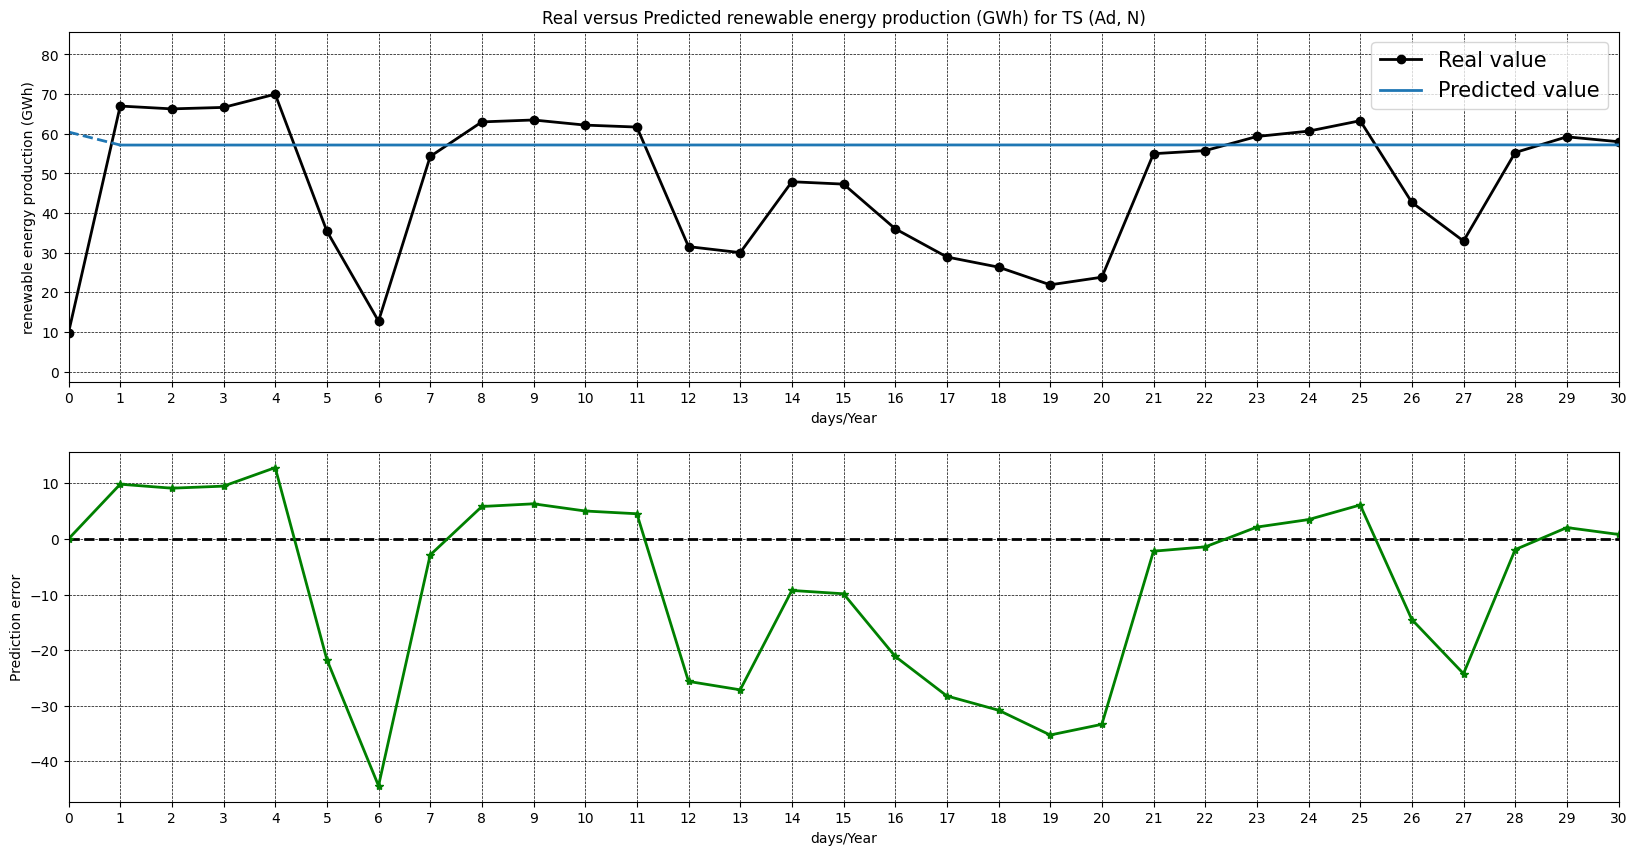

Prediction for 30 days/Year: MAE = 9.82 (14.65%)


In [ ]:
cmap = plt.get_cmap("tab10")
concat = np.concatenate(([df_test.values[-1]], df_test.values.flatten()), axis=0)
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Real versus Predicted ' + ylab + ' for ' + TS_model) 
plt.plot(range(0, concat.shape[0]), concat , 'k-o', linewidth=2)
plt.plot(range(1, stepsToForecast[-1]+1), TS_model_forecast, color = cmap(0), linewidth=2)
plt.plot([0,1], [df_train.values[-1], TS_model_forecast[0]], '--', color = cmap(0), linewidth=2)

plt.xlim([0,len(TS_model_forecast)])
plt.xticks(np.arange(0, len(TS_model_forecast)+1, step=1))
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.legend(['Real value', 'Predicted value'])

plt.subplot(212)
concat2 = np.concatenate((np.array([0]), df_test.values[:stepsToForecast[-1]].flatten()-TS_model_forecast), axis=0)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.plot(range(0, concat2.shape[0]), concat2 , 'g-*', linewidth=2)
plt.xticks(np.arange(0, len(TS_model_forecast)+1, step=1))
plt.xlim([0,len(TS_model_forecast)])
plt.xlabel(xlab)
plt.ylabel('Prediction error')
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.show()

mae  = horizon_mae(np.array([df_test.values[:stepsToForecast[-1]]]), TS_model_forecast, stepsToForecast)
mape = horizon_mape(np.array([df_test.values[:stepsToForecast[-1]]]), TS_model_forecast, stepsToForecast)
for i in np.arange(len(stepsToForecast)):
    print('Prediction for ' + str(stepsToForecast[i]) + ' ' + xlab + ': MAE = ' \
          + str(round(mae[i], 2)) + ' (' + str(round(mape[i], 2)) + '%)' )

In [ ]:
# Forecasted values of ETS model
TS_model_forecast

array([57.15392604, 57.15544441, 57.1569476 , 57.15843576, 57.15990903,
       57.16136758, 57.16281154, 57.16424105, 57.16565628, 57.16705735,
       57.16844441, 57.1698176 , 57.17117706, 57.17252292, 57.17385532,
       57.17517441, 57.1764803 , 57.17777313, 57.17905303, 57.18032013,
       57.18157456, 57.18281645, 57.18404592, 57.1852631 , 57.1864681 ,
       57.18766105, 57.18884208, 57.19001129, 57.19116881, 57.19231476])

## Model Prediction Overview
    Compare: Fitted values of the model with the training data
             Predicted values of the model with the testing data
      
    This section allows to see the forecast of the model that was selected and validated, but also to compare it against other models.

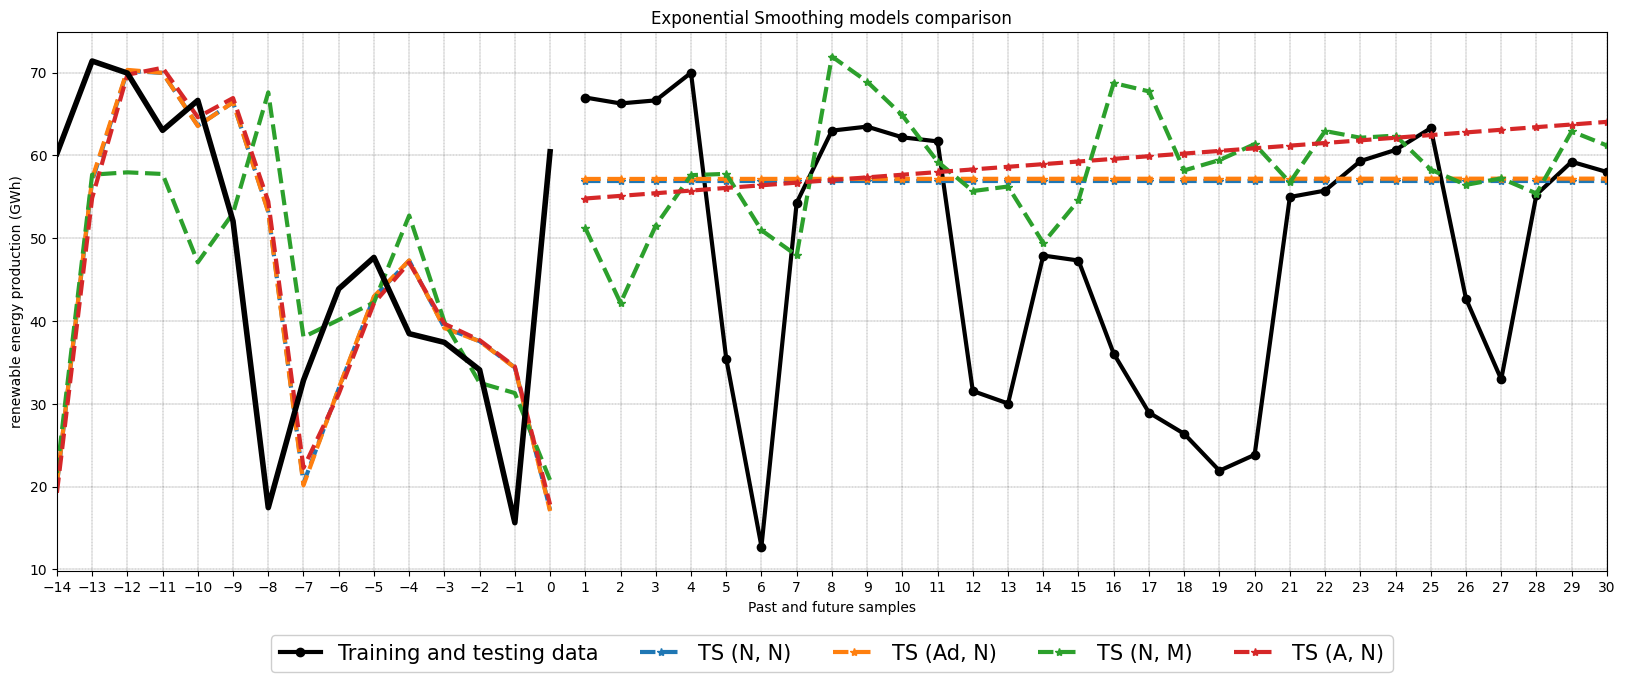

TS (N, N)
Prediction for 30 days/Year: MAE = 10.11 (15.09%)

TS (Ad, N)
Prediction for 30 days/Year: MAE = 9.82 (14.65%)

TS (N, M)
Prediction for 30 days/Year: MAE = 9.24 (13.8%)

TS (A, N)
Prediction for 30 days/Year: MAE = 7.57 (11.3%)



In [ ]:
# Select from 
# TS_str = ['TS (N, N)', 'TS (A, N)', 'TS (Ad, N)', 
#           'TS (N, A)', 'TS (A, A)', 'TS (Ad, A)', 
#           'TS (N, M)', 'TS (A, M)', 'TS (Ad, M)']

TS_labels = ['Train and Test data', 
             'TS (N, N)',
             'TS (Ad, N)',
             'TS (N, M)',
             'TS (A, N)',]


plt.figure(figsize=(20,7))
plt.title('Exponential Smoothing models comparison')
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values[:stepsToForecast[-1]], 'k-o' , linewidth = 3, label='Training and testing data')
plt.legend(TS_labels, loc='upper left')
for i in np.arange(len(TS_labels)-1):
    ETS_plot = plt.plot(1+np.arange(stepsToForecast[-1]), TS[TS_str.index(TS_labels[i+1])].forecast(stepsToForecast[-1]), '--*' , linewidth = 3, label = TS_labels[i+1] )
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, TS[TS_str.index(TS_labels[i+1])].fittedfcast[-previousStepsToShow-1:-1], '--' , linewidth = 3, color=ETS_plot[0].get_color())
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(TS_labels), framealpha=0.95)
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, df_train.values[-previousStepsToShow:], 'k', linewidth = 4 )
plt.grid(color='k', linestyle='--', linewidth=.2)
plt.xlim([1-previousStepsToShow, stepsToForecast[-1]])
plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
plt.xlabel('Past and future samples')
plt.ylabel(ylab)
plt.show()

for i in np.arange(len(TS_labels[1:])):
    mae  = horizon_mae(np.array([df_test.values]), TS[TS_str.index(TS_labels[i+1])].forecast(stepsToForecast[-1]), stepsToForecast)
    mape = horizon_mape(np.array([df_test.values]), TS[TS_str.index(TS_labels[i+1])].forecast(stepsToForecast[-1]), stepsToForecast)
    print(TS_labels[i+1])
    for i in np.arange(len(stepsToForecast)):
        print('Prediction for ' + str(stepsToForecast[i]) + ' ' + xlab + ': MAE = ' \
              + str(round(mae[i], 2)) + ' (' + str(round(mape[i], 2)) + '%)' )
    print("")

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -18845.9
Distribution:                  Normal   AIC:                           37699.8
Method:            Maximum Likelihood   BIC:                           37725.1
                                        No. Observations:                 4147
Date:                Wed, Mar 26 2025   Df Residuals:                     4146
Time:                        19:24:17   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            58.7403      0.618     95.042      0.000 [ 57.529, 59.95

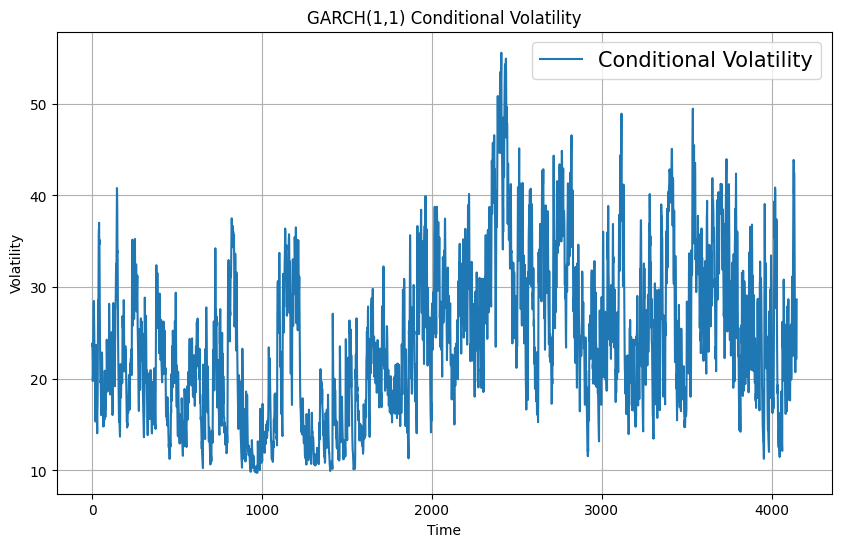

In [ ]:
from arch import arch_model

# Fit a GARCH(1,1) model to the residuals
garch_model = arch_model(df_train.values, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="off")

# Print the summary of the fitted model
print(garch_fit.summary())

# Plot the conditional volatility
plt.figure(figsize=(10, 6))
plt.plot(garch_fit.conditional_volatility, label="Conditional Volatility")
plt.title("GARCH(1,1) Conditional Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.grid()
plt.show()

Predicted values:
[58.74033394 58.74033394 58.74033394 58.74033394 58.74033394 58.74033394
 58.74033394 58.74033394 58.74033394 58.74033394 58.74033394 58.74033394
 58.74033394 58.74033394 58.74033394 58.74033394 58.74033394 58.74033394
 58.74033394 58.74033394 58.74033394 58.74033394 58.74033394 58.74033394
 58.74033394 58.74033394 58.74033394 58.74033394 58.74033394 58.74033394]


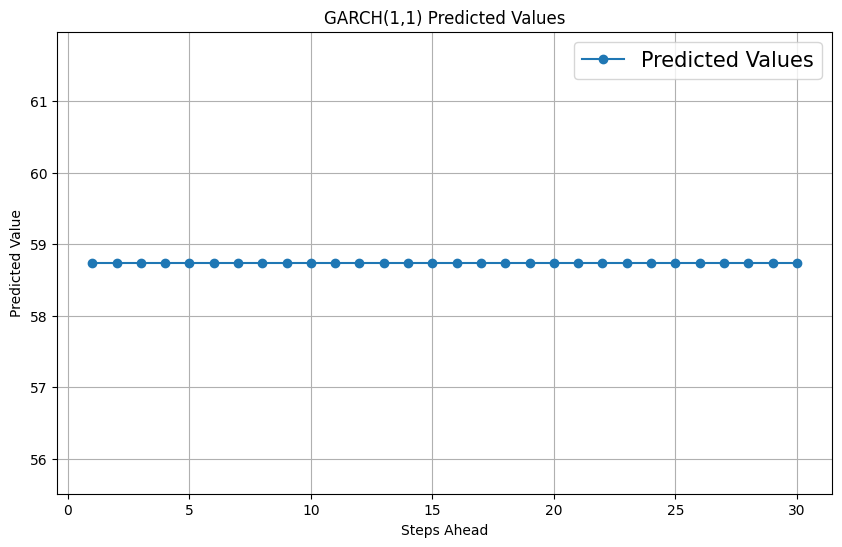

In [ ]:
# Forecast the next 30 steps using the GARCH(1,1) model
forecast_horizon = 30
garch_forecast = garch_fit.forecast(horizon=forecast_horizon)

# Extract the mean forecast
mean_forecast = garch_forecast.mean.iloc[-1].values

# Print the predicted values
print("Predicted values:")
print(mean_forecast)

# Plot the predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(1, forecast_horizon + 1), mean_forecast, marker='o', label="Predicted Values")
plt.title("GARCH(1,1) Predicted Values")
plt.xlabel("Steps Ahead")
plt.ylabel("Predicted Value")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA model parameters
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, seasonal_periods)  # (P, D, Q, s)

# Fit the SARIMA model
sarima_model = SARIMAX(df_train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)

# Print the summary of the fitted model
print(sarima_fit.summary())

# Forecast the next steps
sarima_forecast = sarima_fit.forecast(steps=stepsToForecast[-1])

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_train.index[-100:], df_train.values[-100:], label="Training Data")
plt.plot(df_test.index[:stepsToForecast[-1]], df_test.values[:stepsToForecast[-1]], label="Test Data")
plt.plot(pd.date_range(df_test.index[0], periods=stepsToForecast[-1], freq='D'), sarima_forecast, label="SARIMA Forecast", color='red')
plt.title("SARIMA Model Forecast")
plt.xlabel("Date")
plt.ylabel(ylab)
plt.legend()
plt.grid()
plt.show()